*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

# Working with Time Series


- *Time stamps* reference particular moments in time (e.g., July 4th, 2015 at 7:00am).
- *Time intervals* and *periods* reference a length of time between a particular beginning and end point; for example, the year 2015. Periods usually reference a special case of time intervals in which each interval is of uniform length and does not overlap (e.g., 24 hour-long periods comprising days).
- *Time deltas* or *durations* reference an exact length of time (e.g., a duration of 22.56 seconds).

|Code    | Meaning     | Time span (relative) | Time span (absolute)   |
|--------|-------------|----------------------|------------------------|
| ``Y``  | Year	       | ± 9.2e18 years       | [9.2e18 BC, 9.2e18 AD] |
| ``M``  | Month       | ± 7.6e17 years       | [7.6e17 BC, 7.6e17 AD] |
| ``W``  | Week	       | ± 1.7e17 years       | [1.7e17 BC, 1.7e17 AD] |
| ``D``  | Day         | ± 2.5e16 years       | [2.5e16 BC, 2.5e16 AD] |
| ``h``  | Hour        | ± 1.0e15 years       | [1.0e15 BC, 1.0e15 AD] |
| ``m``  | Minute      | ± 1.7e13 years       | [1.7e13 BC, 1.7e13 AD] |
| ``s``  | Second      | ± 2.9e12 years       | [ 2.9e9 BC, 2.9e9 AD]  |
| ``ms`` | Millisecond | ± 2.9e9 years        | [ 2.9e6 BC, 2.9e6 AD]  |
| ``us`` | Microsecond | ± 2.9e6 years        | [290301 BC, 294241 AD] |
| ``ns`` | Nanosecond  | ± 292 years          | [ 1678 AD, 2262 AD]    |
| ``ps`` | Picosecond  | ± 106 days           | [ 1969 AD, 1970 AD]    |
| ``fs`` | Femtosecond | ± 2.6 hours          | [ 1969 AD, 1970 AD]    |
| ``as`` | Attosecond  | ± 9.2 seconds        | [ 1969 AD, 1970 AD]    |

### Dates and times in pandas: best of both worlds

Pandas builds upon all the tools just discussed to provide a ``Timestamp`` object, which combines the ease-of-use of ``datetime`` and ``dateutil`` with the efficient storage and vectorized interface of ``numpy.datetime64``.
From a group of these ``Timestamp`` objects, Pandas can construct a ``DatetimeIndex`` that can be used to index data in a ``Series`` or ``DataFrame``; we'll see many examples of this below.

For example, we can use Pandas tools to repeat the demonstration from above.
We can parse a flexibly formatted string date, and use format codes to output the day of the week:

In [1]:
import datetime
import numpy as np
import pandas as pd
date = pd.to_datetime("4th of July, 2015")
date

Timestamp('2015-07-04 00:00:00')

In [2]:
date.year

2015

In [5]:
date.strftime('%Y-%m %A')

'2015-07 Saturday'

## Pandas Time Series: Indexing by Time

Where the Pandas time series tools really become useful is when you begin to *index data by timestamps*.
For example, we can construct a ``Series`` object that has time indexed data:

In [11]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04',
                          '2015-07-04', '2015-08-04'])
data = pd.Series([0, 1, 2, 3], index=index)
data

2014-07-04    0
2014-08-04    1
2015-07-04    2
2015-08-04    3
dtype: int64

In [12]:
data['2014-07-04':'2015-07-04']

2014-07-04    0
2014-08-04    1
2015-07-04    2
dtype: int64

In [13]:
data['2015']

2015-07-04    2
2015-08-04    3
dtype: int64

## Pandas Time Series Data Structures

This section will introduce the fundamental Pandas data structures for working with time series data:

- For *time stamps*, Pandas provides the ``Timestamp`` type. As mentioned before, it is essentially a replacement for Python's native ``datetime``, but is based on the more efficient ``numpy.datetime64`` data type. The associated Index structure is ``DatetimeIndex``.
- For *time Periods*, Pandas provides the ``Period`` type. This encodes a fixed-frequency interval based on ``numpy.datetime64``. The associated index structure is ``PeriodIndex``.
- For *time deltas* or *durations*, Pandas provides the ``Timedelta`` type. ``Timedelta`` is a more efficient replacement for Python's native ``datetime.timedelta`` type, and is based on ``numpy.timedelta64``. The associated index structure is ``TimedeltaIndex``.

The most fundamental of these date/time objects are the ``Timestamp`` and ``DatetimeIndex`` objects.
While these class objects can be invoked directly, it is more common to use the ``pd.to_datetime()`` function, which can parse a wide variety of formats.
Passing a single date to ``pd.to_datetime()`` yields a ``Timestamp``; passing a series of dates by default yields a ``DatetimeIndex``:

In [14]:
dates = pd.to_datetime([datetime.datetime(2015, 7, 3), '4th of July, 2015',
                       '2015-Jul-6', '07-07-2015', '20150708'])
dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

Any ``DatetimeIndex`` can be converted to a ``PeriodIndex`` with the ``to_period()`` function with the addition of a frequency code; here we'll use ``'D'`` to indicate daily frequency:

In [17]:
dates.to_period('D')

PeriodIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
             '2015-07-08'],
            dtype='period[D]', freq='D')

A ``TimedeltaIndex`` is created, for example, when a date is subtracted from another:

In [21]:
dates[1] - dates[0]


Timedelta('1 days 00:00:00')

In [22]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

### Regular sequences: ``pd.date_range()``

To make the creation of regular date sequences more convenient, Pandas offers a few functions for this purpose: ``pd.date_range()`` for timestamps, ``pd.period_range()`` for periods, and ``pd.timedelta_range()`` for time deltas.
We've seen that Python's ``range()`` and NumPy's ``np.arange()`` turn a startpoint, endpoint, and optional stepsize into a sequence.
Similarly, ``pd.date_range()`` accepts a start date, an end date, and an optional frequency code to create a regular sequence of dates.
By default, the frequency is one day:

In [23]:
pd.date_range('2015-07-03', '2015-07-10')

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

Alternatively, the date range can be specified not with a start and endpoint, but with a startpoint and a number of periods:

In [24]:
pd.date_range('2015-07-03', periods=8)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

The spacing can be modified by altering the ``freq`` argument, which defaults to ``D``.
For example, here we will construct a range of hourly timestamps:

In [25]:
pd.date_range('2015-07-03', periods=8, freq='H')

DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='H')

To create regular sequences of ``Period`` or ``Timedelta`` values, the very similar ``pd.period_range()`` and ``pd.timedelta_range()`` functions are useful.
Here are some monthly periods:

In [26]:
pd.period_range('2015-07', periods=8, freq='M')

PeriodIndex(['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02'],
            dtype='period[M]', freq='M')

And a sequence of durations increasing by an hour:

In [27]:
pd.timedelta_range(0, periods=10, freq='H')

TimedeltaIndex(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00',
                '05:00:00', '06:00:00', '07:00:00', '08:00:00', '09:00:00'],
               dtype='timedelta64[ns]', freq='H')

## Frequencies and Offsets

Fundamental to these Pandas time series tools is the concept of a frequency or date offset.
Just as we saw the ``D`` (day) and ``H`` (hour) codes above, we can use such codes to specify any desired frequency spacing.
The following table summarizes the main codes available:

| Code   | Description         | Code   | Description          |
|--------|---------------------|--------|----------------------|
| ``D``  | Calendar day        | ``B``  | Business day         |
| ``W``  | Weekly              |        |                      |
| ``M``  | Month end           | ``BM`` | Business month end   |
| ``Q``  | Quarter end         | ``BQ`` | Business quarter end |
| ``A``  | Year end            | ``BA`` | Business year end    |
| ``H``  | Hours               | ``BH`` | Business hours       |
| ``T``  | Minutes             |        |                      |
| ``S``  | Seconds             |        |                      |
| ``L``  | Milliseonds         |        |                      |
| ``U``  | Microseconds        |        |                      |
| ``N``  | nanoseconds         |        |                      |

In [29]:
pd.date_range('2015-07-01', periods=5, freq='B')

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06',
               '2015-07-07'],
              dtype='datetime64[ns]', freq='B')

The monthly, quarterly, and annual frequencies are all marked at the end of the specified period.
By adding an ``S`` suffix to any of these, they instead will be marked at the beginning:

| Code    | Description            | Code    | Description            |
|---------|------------------------|---------|------------------------|
| ``MS``  | Month start            |``BMS``  | Business month start   |
| ``QS``  | Quarter start          |``BQS``  | Business quarter start |
| ``AS``  | Year start             |``BAS``  | Business year start    |

Additionally, you can change the month used to mark any quarterly or annual code by adding a three-letter month code as a suffix:

- ``Q-JAN``, ``BQ-FEB``, ``QS-MAR``, ``BQS-APR``, etc.
- ``A-JAN``, ``BA-FEB``, ``AS-MAR``, ``BAS-APR``, etc.

In the same way, the split-point of the weekly frequency can be modified by adding a three-letter weekday code:

- ``W-SUN``, ``W-MON``, ``W-TUE``, ``W-WED``, etc.

On top of this, codes can be combined with numbers to specify other frequencies.
For example, for a frequency of 2 hours 30 minutes, we can combine the hour (``H``) and minute (``T``) codes as follows:

In [66]:
pd.timedelta_range(0, periods=9, freq="2H30T")

TimedeltaIndex(['00:00:00', '02:30:00', '05:00:00', '07:30:00', '10:00:00',
                '12:30:00', '15:00:00', '17:30:00', '20:00:00'],
               dtype='timedelta64[ns]', freq='150T')

## Resampling, Shifting, and Windowing

The ability to use dates and times as indices to intuitively organize and access data is an important piece of the Pandas time series tools.
The benefits of indexed data in general (automatic alignment during operations, intuitive data slicing and access, etc.) still apply, and Pandas provides several additional time series-specific operations.

We will take a look at a few of those here, using some stock price data as an example.
Because Pandas was developed largely in a finance context, it includes some very specific tools for financial data.
For example, the accompanying ``pandas-datareader`` package (installable via ``conda install pandas-datareader``), knows how to import financial data from a number of available sources, including Yahoo finance, Google Finance, and others.
Here we will load Google's closing price history:

In [32]:
#!pip install pandas_datareader

In [33]:
from pandas_datareader import data

goog = data.DataReader('GOOG', start='2004', end='2016',
                       data_source='yahoo')
goog.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,51.835709,47.800831,49.813286,49.982655,44871300.0,49.982655
2004-08-20,54.336334,50.062355,50.316402,53.952770,22942800.0,53.952770
2004-08-23,56.528118,54.321388,55.168217,54.495735,18342800.0,54.495735
2004-08-24,55.591629,51.591621,55.412300,52.239193,15319700.0,52.239193
2004-08-25,53.798351,51.746044,52.284027,52.802086,9232100.0,52.802086


In [34]:
goog = goog['Close']

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

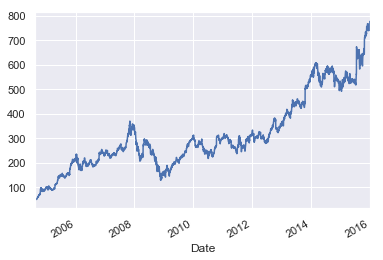

In [36]:
goog.plot();

### Resampling and converting frequencies

One common need for time series data is resampling at a higher or lower frequency.
This can be done using the ``resample()`` method, or the much simpler ``asfreq()`` method.
The primary difference between the two is that ``resample()`` is fundamentally a *data aggregation*, while ``asfreq()`` is fundamentally a *data selection*.

Taking a look at the Google closing price, let's compare what the two return when we down-sample the data.
Here we will resample the data at the end of business year:

In [40]:
goog.resample('BA').mean()

Date
2004-12-31     75.617206
2005-12-30    138.360933
2006-12-29    204.824916
2007-12-31    268.369305
2008-12-31    231.558071
2009-12-31    219.023214
2010-12-31    266.811472
2011-12-30    283.424738
2012-12-31    320.208021
2013-12-31    440.470378
2014-12-31    559.803290
2015-12-31    602.005681
2016-12-30           NaN
Freq: BA-DEC, Name: Close, dtype: float64

In [41]:
goog.asfreq('BA')

Date
2004-12-31     96.035034
2005-12-30    206.655411
2006-12-29    229.380234
2007-12-31    344.448914
2008-12-31    153.250580
2009-12-31    308.832428
2010-12-31    295.875977
2011-12-30    321.744019
2012-12-31    352.369232
2013-12-31    558.262512
2014-12-31    524.958740
2015-12-31    758.880005
Freq: BA-DEC, Name: Close, dtype: float64

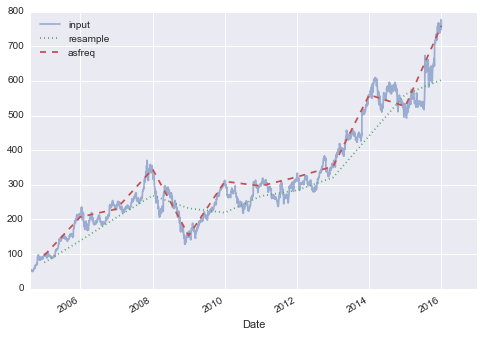

In [29]:
goog.plot(alpha=0.5, style='-')
goog.resample('BA').mean().plot(style=':')
goog.asfreq('BA').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

Notice the difference: at each point, ``resample`` reports the *average of the previous year*, while ``asfreq`` reports the *value at the end of the year*.

For up-sampling, ``resample()`` and ``asfreq()`` are largely equivalent, though resample has many more options available.
In this case, the default for both methods is to leave the up-sampled points empty, that is, filled with NA values.
Just as with the ``pd.fillna()`` function discussed previously, ``asfreq()`` accepts a ``method`` argument to specify how values are imputed.
Here, we will resample the business day data at a daily frequency (i.e., including weekends):

In [19]:
goog.iloc[:10].asfreq('D')

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-21          NaN
2004-08-22          NaN
2004-08-23    54.495735
2004-08-24    52.239193
2004-08-25    52.802086
2004-08-26    53.753517
2004-08-27    52.876804
2004-08-28          NaN
2004-08-29          NaN
2004-08-30    50.814533
2004-08-31    50.993862
2004-09-01    49.937820
Freq: D, Name: Close, dtype: float64

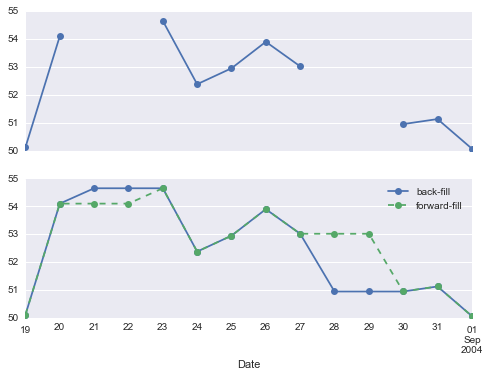

In [30]:
fig, ax = plt.subplots(2, sharex=True)
data = goog.iloc[:10]

data.asfreq('D').plot(ax=ax[0], marker='o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

### Time-shifts

Another common time series-specific operation is shifting of data in time.
Pandas has two closely related methods for computing this: ``shift()`` and ``tshift()``
In short, the difference between them is that ``shift()`` *shifts the data*, while ``tshift()`` *shifts the index*.
In both cases, the shift is specified in multiples of the frequency.

Here we will both ``shift()`` and ``tshift()`` by 900 days; 

In [47]:
goog.asfreq('D').tshift(10)

Date
2004-08-29     49.982655
2004-08-30     53.952770
2004-08-31           NaN
2004-09-01           NaN
2004-09-02     54.495735
2004-09-03     52.239193
2004-09-04     52.802086
2004-09-05     53.753517
2004-09-06     52.876804
2004-09-07           NaN
2004-09-08           NaN
2004-09-09     50.814533
2004-09-10     50.993862
2004-09-11     49.937820
2004-09-12     50.565468
2004-09-13     49.818268
2004-09-14           NaN
2004-09-15           NaN
2004-09-16           NaN
2004-09-17     50.600338
2004-09-18     50.958992
2004-09-19     50.963974
2004-09-20     52.468334
2004-09-21           NaN
2004-09-22           NaN
2004-09-23     53.549286
2004-09-24     55.536835
2004-09-25     55.790882
2004-09-26     56.772205
2004-09-27     58.525631
                 ...    
2015-12-12    762.380005
2015-12-13    752.539978
2015-12-14    766.809998
2015-12-15           NaN
2015-12-16           NaN
2015-12-17    763.250000
2015-12-18    762.369995
2015-12-19    751.609985
2015-12-20    749.46

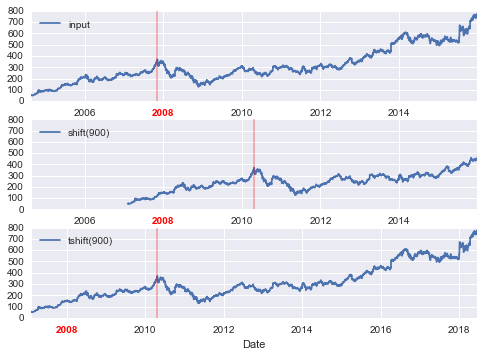

In [31]:
fig, ax = plt.subplots(3, sharey=True)

# apply a frequency to the data
goog = goog.asfreq('D', method='pad')

goog.plot(ax=ax[0])
goog.shift(900).plot(ax=ax[1])
goog.tshift(900).plot(ax=ax[2])

# legends and annotations
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')

ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['tshift(900)'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

We see here that ``shift(900)`` shifts the *data* by 900 days, pushing some of it off the end of the graph (and leaving NA values at the other end), while ``tshift(900)`` shifts the *index values* by 900 days.

A common context for this type of shift is in computing differences over time. For example, we use shifted values to compute the one-year return on investment for Google stock over the course of the dataset:

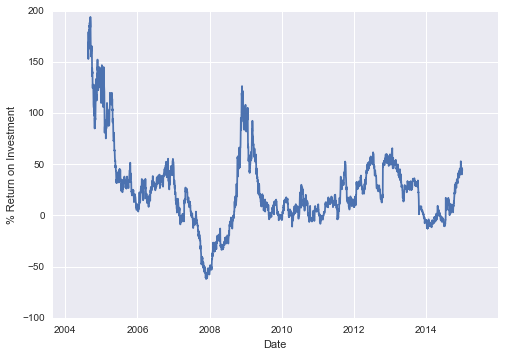

In [32]:
ROI = 100 * (goog.tshift(-365) / goog - 1)
ROI.plot()
plt.ylabel('% Return on Investment');

This helps us to see the overall trend in Google stock: thus far, the most profitable times to invest in Google have been (unsurprisingly, in retrospect) shortly after its IPO, and in the middle of the 2009 recession.

### Rolling windows

Rolling statistics are a third type of time series-specific operation implemented by Pandas.
These can be accomplished via the ``rolling()`` attribute of ``Series`` and ``DataFrame`` objects, which returns a view similar to what we saw with the ``groupby`` operation (see [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb)).
This rolling view makes available a number of aggregation operations by default.

For example, here is the one-year centered rolling mean and standard deviation of the Google stock prices:

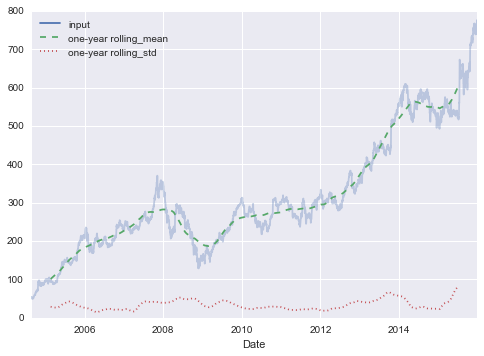

In [33]:
rolling = goog.rolling(365, center=True)

data = pd.DataFrame({'input': goog,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)